# Fashion MNIST with Keras and Deep Learning

In [1]:
# import the necessary packages

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

Using TensorFlow backend.


In [2]:
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding = "same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Conv2D(32, (3, 3), padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = chanDim))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Conv2D(64, (3, 3), padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = chanDim))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [3]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
#matplotlib.use("Agg")
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.utils import np_utils
from imutils import build_montages
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2

# initialize the number of epochs train for, base learning rate, and batch size
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 32

In [4]:
# the dataset will be automatically downloaded)
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
    trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
    testX = testX.reshape((testX.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))

[INFO] loading Fashion MNIST...


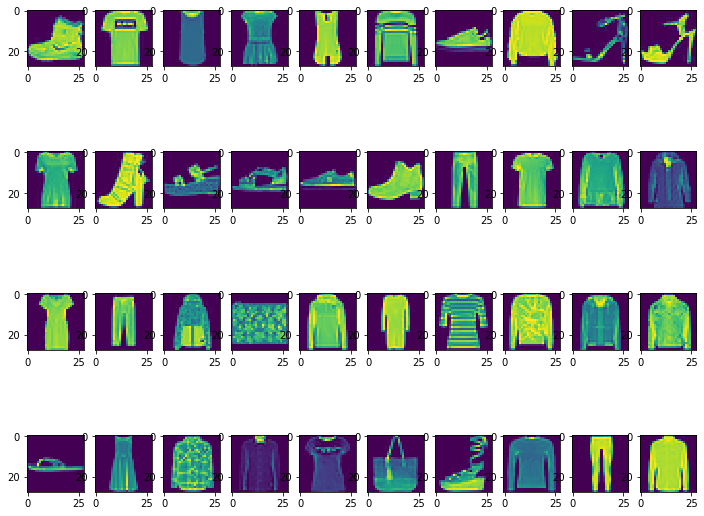

In [28]:
%matplotlib inline
# preview the images first
plt.figure(figsize = (12, 10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(trainX[i].reshape((28, 28)), interpolation = 'nearest')
plt.show()

In [5]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [6]:
# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)

In [7]:
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [8]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr = INIT_LR, momentum = 0.9, decay = INIT_LR / NUM_EPOCHS)
model = MiniVGGNet.build(width = 28, height = 28, depth = 1, classes = 10)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

[INFO] compiling model...


In [25]:
# train the network
print("[INFO] training model...")
H = model.fit(trainX, trainY,
    validation_data = (testX, testY),
    batch_size = BS, epochs = NUM_EPOCHS)

[INFO] training model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 38s 637us/step - loss: 0.1439 - accuracy: 0.9474 - val_loss: 0.1798 - val_accuracy: 0.9366
Epoch 2/25
60000/60000 [==============================] - 37s 624us/step - loss: 0.1428 - accuracy: 0.9478 - val_loss: 0.1827 - val_accuracy: 0.9340
Epoch 3/25
60000/60000 [==============================] - 38s 625us/step - loss: 0.1435 - accuracy: 0.9472 - val_loss: 0.1767 - val_accuracy: 0.9367
Epoch 4/25
60000/60000 [==============================] - 37s 625us/step - loss: 0.1432 - accuracy: 0.9474 - val_loss: 0.1798 - val_accuracy: 0.9345
Epoch 5/25
60000/60000 [==============================] - 37s 624us/step - loss: 0.1410 - accuracy: 0.9480 - val_loss: 0.1788 - val_accuracy: 0.9354
Epoch 6/25
60000/60000 [==============================] - 37s 624us/step - loss: 0.1400 - accuracy: 0.9482 - val_loss: 0.1805 - val_accuracy: 0.9357
Epoch 7/25
60000/60000 [=======

In [47]:
# save model and architecture to single file
model.save("model_fashion.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
# serialize weights to HDF5
model.save_weights("model_fashion1.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
from keras.models import load_model
# load model
model = load_model('model_fashion.h5')

In [20]:
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)       

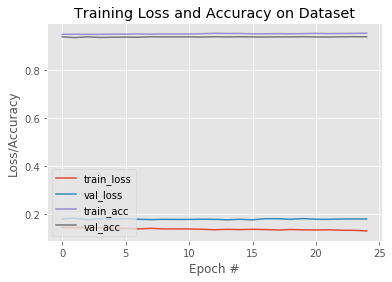

In [26]:
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig("plot.png")

In [11]:
score = model.evaluate(testX, testY, verbose=0)

In [12]:
print('Test loss:', score[0])

Test loss: 0.18146788820028306


In [13]:
print('Test accuracy:', score[1])

Test accuracy: 0.9344000220298767


In [21]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
# Predict the values from the validation dataset
Y_pred = model.predict(testX)

In [18]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

In [19]:
# Convert validation observations to one hot vectors
Y_true = np.argmax(testY, axis = 1) 

In [22]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

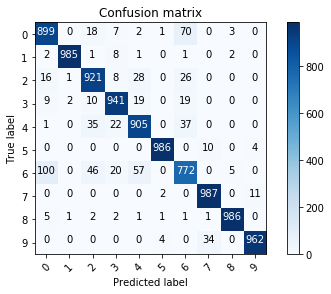

In [23]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [27]:
print(H.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [28]:
accuracy = H.history['accuracy']
val_accuracy = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(len(accuracy))

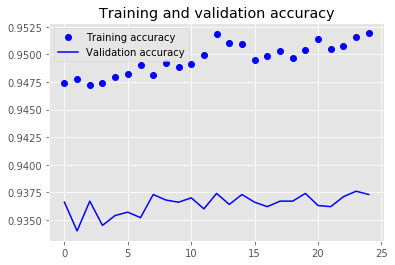

In [29]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

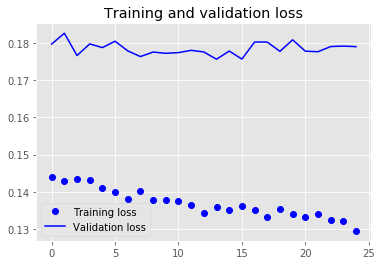

In [30]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)
errors

array([False, False, False, ..., False, False, False])

In [35]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = testX[errors]

In [74]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize = (10, 10))
    plt.grid(False)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

In [37]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

In [45]:
# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

In [47]:
# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

In [49]:
# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

In [41]:
# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

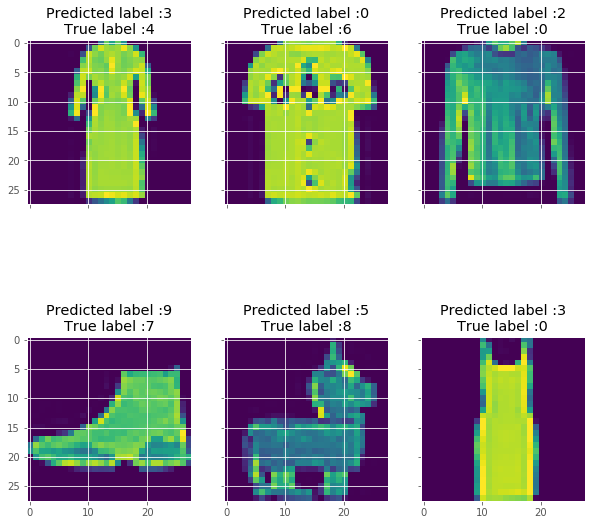

In [73]:
# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

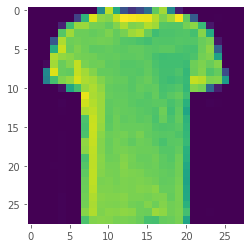

In [66]:
test_im = trainX[154]
plt.grid(False)
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

# Classifcation Report

In [77]:
# Predict the values from the validation dataset
Y_pred = model.predict(testX)

In [79]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true_classes = np.argmax(testY, axis = 1)

In [80]:
Y_pred_classes[:5], Y_true_classes[:5]

(array([9, 2, 1, 1, 6]), array([9, 2, 1, 1, 6]))

In [81]:
from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Y_true_classes, Y_pred_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.88      0.90      0.89      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.91      0.91      0.91      1000
     Class 3       0.94      0.94      0.94      1000
     Class 4       0.89      0.91      0.90      1000
     Class 5       0.99      0.99      0.99      1000
     Class 6       0.83      0.79      0.81      1000
     Class 7       0.97      0.98      0.98      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [86]:
import pandas as pd
predicted_classes = model.predict_classes(testX)
submissions = pd.DataFrame({"ImageId" : list(range(1, len(predicted_classes) + 1)), "Label" : predicted_classes})
submissions.to_csv("asd.csv", index=False, header=True)

In [84]:
predicted_classes = model.predict_classes(testX)

In [85]:
predicted_classes

array([9, 2, 1, ..., 8, 1, 5])

In [87]:
json_string = model.to_json()